# 1. Data prepration
    
## 1.1 Load data and preprocessing
In this part we import libraries and data set. Data set has 9 columns and 2075259 samples. It also has missing values. The first step is to load data set and handle missing values. Also the first two columns contain time and date, which we eliminate in our first version of code.  

In [143]:
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("household_power_consumption.txt",";")

print("The size of data set is:",data.shape)
print("The first three rows of data set:\n",data.head(3))
print("The last three rows of data set:\n",data.tail(3))

X = pd.DataFrame(data.iloc[:,2:6], columns=["Global_active_power","Global_reactive_power","Voltage","Global_intensity"])
Y = pd.DataFrame(data.iloc[:,7], columns=["Sub_metering_2"])

X = X.replace({'?':0})
Y = Y.replace({'?':0})

/home/shahab/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The size of data set is: (2075259, 9)
The first three rows of data set:
          Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
The last three rows of data set:
                Date      Time Global_active_power Global_reactive_power  \
2075256  26/11/2010  21:00:00               0.938                     0   
2075257  26/11/2010  21:01:00               0.934                     0   
2075258  26/11/2010  21:02:00               0.932                     0   

        Vol

## 1.2 train and test sets
Befor starting the training we need to split our data to train and test. In traditional learning algorithms, people usually use 70%/30% train/test or 60%/20%/20% train/dev/test set. Nowadays, because of having large data sets, people usually use 98%/1%/1% train/dev/test set. In this assignment we used the traditional way of spliting data into train and test with the ratio of 70%/30% of train/test. 

In [3]:
X_features = X.columns
Y_features = Y.columns
XY = pd.concat([X[X_features], Y[Y_features]], axis=1)

# Split XY into training set and test set of equal size
train, test = train_test_split(XY, test_size = 0.30)
# Sort the train and test sets after index (which became unsorted through sampling)
train = train.sort_index(axis=0)
test = test.sort_index(axis=0)

# Extract X,Y components from test and train sets
X_train = train[X_features].astype(float); X_test = test[X_features].astype(float)
Y_train = train[Y_features].astype(float); Y_test = test[Y_features].astype(float)

print("Size of train set (X): ",X_train.shape)
print("Size of train set (Y): ",Y_train.shape)
print("Size of test set (X): ",X_test.shape)
print("Size of test set (Y): ",Y_test.shape)

Size of train set (X):  (1452681, 4)
Size of train set (Y):  (1452681, 1)
Size of test set (X):  (622578, 4)
Size of test set (Y):  (622578, 1)


# 2. Logistic ridge regression with different optimizers

The goal of this part is to implement logistic ridge regression with four different optimizers (GD, SGD, SAG, SVRG). We define logistic ridge as following:  

\begin{equation*}
f(w) = \frac{1}{N} \sum_{i\in[N]} f_i(w) + \lambda ||w||_2^2
\end{equation*}

where 

\begin{equation*}
f_i(w) = \log(1+\exp(y_iw^Tx_i))
\end{equation*}

In the following section we each of optimizers and will try to optimize the specified goal function.

In [12]:
def function_gradient_GD(X, Y, w, lambda_):
    Z = np.matmul(X,np.diagflat(Y))
    D,N = Z.shape
    Z_ = -1 * np.matmul(w.T , Z)
    A = 1/(1+np.exp(Z_))
    A_ = np.diagflat(A-1)
    G = 1 / N * np.sum(np.matmul(Z , A_), axis=1,keepdims=True) + 2 * lambda_ * w
    return G

In [13]:
X = np.array([[2,3,3],[1,4,3]])
Y = np.array([[1],[2],[5]])
w = np.array([[0.01],[0.21]])

print(function_gradient_GD(X,Y,w,0.1))

[[-0.76964991]
 [-0.68160782]]


In [187]:
def solver(x,y, w, alpha = 0.1, num_iters = 1000, lambda_ = 0.1, epsilon = 0.0001, optimizer = "GD",mem=False):
    if (optimizer == "GD") :
        for i in range(num_iters):
            g = function_gradient_GD(x, y, w, lambda_)
            w = w - alpha * g
            if (i%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for GD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
            if (np.linalg.norm(g) <= epsilon):
                break
    elif (optimizer == "SGD"):
        for i in range(num_iters):
            D,N = x.shape
            sample_no = int(np.random.random(1) * N)
            Z = np.matmul(x,np.diagflat(y))
            A = -1 * np.matmul(w.T, Z[:,i])
            G = (Z[:,[i]]*float(1/(1+np.exp(A))-1))+ 2 * lambda_ * w
            w = w - alpha * G
            if (i%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for SGD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                
    elif (optimizer == "SVRG"):
        T = 100
        K = math.floor(num_iters/T)
        Z = np.matmul(x,np.diagflat(y))
        N = x.shape[1]
        for k in range(K):
            wz = np.matmul(w.T , Z)
            diag = np.diagflat(1/(1+np.exp(-1*wz))-np.ones((1,N)))
            Ga_ = np.matmul(Z , diag)
            ga_ = (1/N) * np.matmul(Ga_ , np.ones((N,1)))
            for t in range(T):
                r = int(np.random.random(1) * N)
                col = Z[:,[r]]
                #col = col.reshape((col.shape[0],1))
                g = np.matmul(col , (1/(1+np.exp(-1 * np.matmul(w.T , col)))-1))
                Ga_col = Ga_[:,r]
                Ga_col = Ga_col.reshape(Ga_col.shape[0],1)
                w = w - alpha * (g - Ga_col + ga_ + 2 * lambda_ * w)
            if (k%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for SVRG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
            
    elif (optimizer == "SAG"):
        Z = np.matmul(x,np.diagflat(y))
        d = x.shape[0]
        N = x.shape[1]
        G = np.zeros((d,N))

        for k in range(num_iters):
            r = int(np.random.random(1) * N)
            col = Z[:,r].reshape(Z[:,r].shape[0],1)
            B = np.matmul(col ,(1/(1 + np.exp(-1 * np.matmul(w.T,col))) - 1))
            B = B.reshape(B.shape[0])
            G[:,r] = B
            g = (1/N) * np.matmul(G , np.ones((N,1)))  + 2 * lambda_ * w
            w = w - alpha * g
            if (k%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for SAG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
            
            
    return w

In [146]:
def cost(x,y,w,lambda_ = 0.01):
    D, N = x.shape
    value = 0
    for i in range(N):
        Z = -1 * y[i] * np.matmul(w.T , (x[:,i]).reshape(D,1))
        value += np.log(1+np.exp(Z))
    norm = np.linalg.norm(w)
    c = lambda_ * norm ** 2
    return value/N + c

In [126]:
X = np.array([[2,3,5],[1,4,4]])
Y = np.array([[1],[2],[7]])
w = np.array([[0.01],[0.21]])

print(cost(X,Y,w,0.1))

[[ 0.25389454]]


In [140]:
y = np.array(Y_train.iloc[0:6000])
x = np.array(X_train.iloc[0:6000,:])

N,D = x.shape
w = np.random.rand(D,1)*0.01

##################GD###################
start = time.time()
gde = solver(x.T,y,w,num_iters=100)
end = time.time()
print("Weights of GD after convergence: \n",gde)

err = cost(x.T,y,gde)
print("Cost of GD after convergence: ",err)

print("Training time for GD: ", end-start)

##################SGD###################
start = time.time()
gde = solver(x.T,y,w, num_iters=500,optimizer = "SGD")
end = time.time()
print("Weights of SGD after convergence: \n",gde)

err = cost(x.T,y,gde)
print("Cost of SGD after convergence: ",err)
print("Training time for SGD: ", end-start)
##################SVRG###################
start = time.time()
gde = solver(x.T,y,w, num_iters=1000,optimizer = "SVRG")
end = time.time()
print("Weights of SVRG after convergence: \n",gde)

err = cost(x.T,y,gde)
print("Cost of SVRG after convergence: ",err)
print("Training time for SVRG: ", end-start)
##################SAG###################
start = time.time()
gde = solver(x.T,y,w, num_iters=100,optimizer = "SAG")
end = time.time()
print("Weights of SAG after convergence: \n",gde)

err = cost(x.T,y,gde)
print("Cost of SAG after convergence: ",err)
print("Training time for SAG: ", end-start)

Weights of GD after convergence: 
 [[  1.39374748e-03]
 [  1.24737032e-04]
 [  1.30549938e-01]
 [  4.42132906e-03]]
Cost of GD after convergence:  [[ 0.47035549]]
Training time for GD:  24.653496980667114
Weights of SGD after convergence: 
 [[  3.99765007e-04]
 [  1.23881580e-05]
 [  3.82345319e-02]
 [  1.69091126e-03]]
Cost of SGD after convergence:  [[ 0.47021625]]
Training time for SGD:  61.7726354598999
Weights of SVRG after convergence: 
 [[  2.59821442e-04]
 [  2.56473699e-05]
 [  3.57130200e-02]
 [  1.10374980e-03]]
Cost of SVRG after convergence:  [[ 0.47022849]]
Training time for SVRG:  1.4326896667480469
Weights of SAG after convergence: 
 [[  1.02091694e-03]
 [  5.44494501e-05]
 [  5.61698936e-02]
 [  2.77872666e-03]]
Cost of SAG after convergence:  [[ 0.4702167]]
Training time for SAG:  0.1322011947631836


In [170]:
ti= np.zeros((50,4))
cost_= np.zeros((50,4))
for i in range(50):
    print("......",i,".......")
    ##################GD###################
    start = time.time()
    gde = solver(x.T,y,w,num_iters=i)
    end = time.time()

    cost_[i,0] = cost(x.T,y,gde)

    ti[i,0] = end-start

    ##################SGD###################
    start = time.time()
    gde = solver(x.T,y,w, num_iters=i,optimizer = "SGD")
    end = time.time()

    cost_[i,1] = cost(x.T,y,gde)
    
    ti[i,1] = end-start
    ##################SVRG###################
    start = time.time()
    gde = solver(x.T,y,w, num_iters=i,optimizer = "SVRG")
    end = time.time()

    cost_[i,2] = cost(x.T,y,gde)
    
    ti[i,2] = end-start
    ##################SAG###################
    start = time.time()
    gde = solver(x.T,y,w, num_iters=i,optimizer = "SAG")
    end = time.time()

    cost_[i,3] = cost(x.T,y,gde)
    ti[i,3] = end-start
    print("GD","cost:",cost_[i,0],"time:",ti[i,0])
    print("SGD","cost:",cost_[i,1],"time:",ti[i,1])
    print("SVRG","cost:",cost_[i,2],"time:",ti[i,2])
    print("SAG","cost:",cost_[i,3],"time:",ti[i,3])

...... 0 .......
GD cost: 0.509545415051 time: 1.71661376953e-05
SGD cost: 0.509545415051 time: 7.15255737305e-06
SVRG cost: 0.509545415051 time: 0.125368833542
SAG cost: 0.509545415051 time: 0.124978065491
...... 1 .......
GD cost: 0.479503166113 time: 0.249886035919
SGD cost: 0.653963938836 time: 0.122185945511
SVRG cost: 0.509545415051 time: 0.121023893356
SAG cost: 0.510720298015 time: 0.120092868805
...... 2 .......
GD cost: 0.479134160299 time: 0.49355173111
SGD cost: 0.646686286422 time: 0.250734567642
SVRG cost: 0.509545415051 time: 0.126273155212
SAG cost: 0.511906577211 time: 0.126656293869
...... 3 .......
GD cost: 0.478779767116 time: 0.773363828659
SGD cost: 0.639696829044 time: 0.368747472763
SVRG cost: 0.509545415051 time: 0.116564512253
SAG cost: 0.505485304341 time: 0.119034528732
...... 4 .......
GD cost: 0.478439407902 time: 1.01314878464
SGD cost: 0.632984154178 time: 0.504722356796
SVRG cost: 0.509545415051 time: 0.126829385757
SAG cost: 0.48162306534 time: 0.12205

[ 0.50954542  0.65396394  0.64668629  0.63969683  0.63298415  0.6265373
  0.62034574  0.61439937  0.60868848  0.60320373  0.59793618  0.59287723
  0.58801861  0.58335239  0.57887096  0.57456699  0.57043346  0.56646361
  0.56265097  0.55898931  0.55547265  0.55209526  0.5488516   0.5457364
  0.54274456  0.53987119  0.53711161  0.53446131  0.53191597  0.52947141
  0.52712366  0.52486889  0.5227034   0.52062366  0.51862629  0.516708
  0.51486569  0.51309633  0.51139703  0.50976503  0.50819765  0.50669234
  0.50524665  0.5038582   0.50252473  0.50124407  0.50001413  0.49883289
  0.49769843  0.49660889]


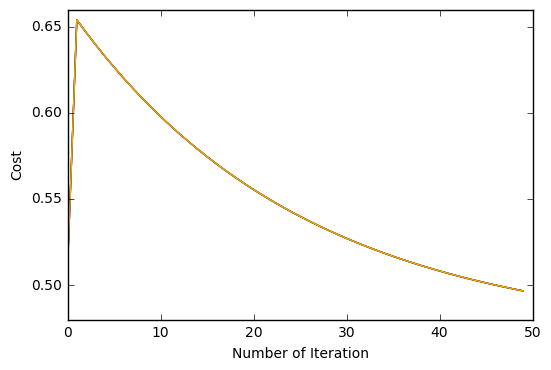

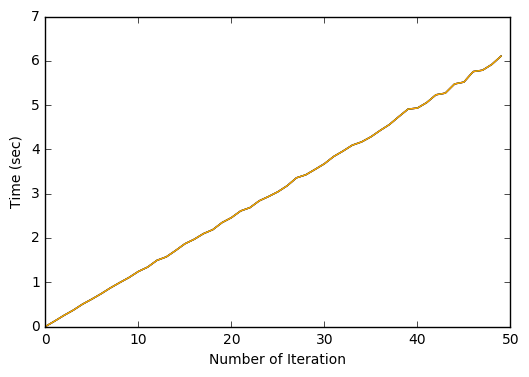

In [171]:
import matplotlib.pyplot as plt

print(cost_[:,1])
plt.plot(cost_[:,1],color="red")
plt.plot(cost_[:,1],color="blue")
plt.plot(cost_[:,1],color="green")
plt.plot(cost_[:,1],color="orange")
plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.show()

plt.plot(ti[:,1],color="red")
plt.plot(ti[:,1],color="blue")
plt.plot(ti[:,1],color="green")
plt.plot(ti[:,1],color="orange")
plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.show()

# 2.1 results 

As we can compare we can see that the GD is better than other algorithms in terms of accuracy but it is slower than other algorithms. GD even with just 100 of iteration take a long time to be trained (24 seconds in comparison with 10 seconds for SGD for example) and interestingly it converges just with these few numbers of iterations. Results shows that SAG is really good in comparision with others. This algorithm is as accurate as others and also it is really fast.

# 3. Tunning the lambda paramter

To tune hyper-paramter there are different methods. One methos is to define space for hyper-parameters of the model, for example here we have a space with just one dimension. Then we can define points in this space and train our model with the paramters of each point. The following image shows how we can define and search space to tune hyper-paramters. Here we consider lambda as a hyper-paramter of the model and then with different values of lambda we compute cost (error metric, it can be MSE, NMAE, or any other metric here for simplicity we used cost which was defined before) for each model. 

![title](search.png)

As the figure shows we can search the space with two different approaches.

- Grid search
- Random search

Both of these methods are very common but the Random seach in first round is better. Because in this search it is mostly probable to find a good solution. We can also use our knowledge to define the space, for example we can define a logarithmic scale for our space. We tune this hyper-paramter just for the logistic ridge regression with SAG optimizer.

In [153]:
space = [0.01,0.5, 0.1,0.5, 1,5, 10]

for la in space:
    start = time.time()
    gde = solver(x.T,y,w, num_iters=100,optimizer = "SAG", lambda_=la)
    end = time.time()
    print("Weights of SAG after convergence: \n",gde)

    err = cost(x.T,y,gde)
    print("Cost of SAG after convergence: ",err)
    print("Training time for SAG: ", end-start)

Weights of SAG after convergence: 
 [[ 0.00418148]
 [ 0.00030832]
 [ 0.13719498]
 [ 0.0085185 ]]
Cost of SAG after convergence:  [[ 0.47037396]]
Training time for SAG:  0.12849712371826172
Weights of SAG after convergence: 
 [[  2.01454265e-04]
 [  1.61875722e-05]
 [  2.28693963e-02]
 [  8.39541611e-04]]
Cost of SAG after convergence:  [[ 0.47086994]]
Training time for SAG:  0.13105249404907227
Weights of SAG after convergence: 
 [[  9.08582743e-04]
 [  8.63380887e-05]
 [  9.51998621e-02]
 [  2.38921604e-03]]
Cost of SAG after convergence:  [[ 0.47027553]]
Training time for SAG:  0.1317579746246338
Weights of SAG after convergence: 
 [[  7.30938447e-05]
 [  1.30636065e-05]
 [  2.24751327e-02]
 [  3.11898802e-04]]
Cost of SAG after convergence:  [[ 0.47094041]]
Training time for SAG:  0.13200068473815918
Weights of SAG after convergence: 
 [[  1.04628189e-04]
 [  1.21849787e-05]
 [  1.98569460e-02]
 [  4.40620042e-04]]
Cost of SAG after convergence:  [[ 0.4715965]]
Training time for SAG

In [155]:
space = [0.070, 0.075,0.080, 0.085, 0.090, 0.100, 0.105, 0.110, 0.115, 0.120, 0.125, 0.130]

for la in space:
    start = time.time()
    gde = solver(x.T,y,w, num_iters=100,optimizer = "SAG", lambda_=la)
    end = time.time()
    print("Weights of SAG after convergence: \n",gde)

    err = cost(x.T,y,gde)
    print("Cost of SAG after convergence: ",err)
    print("Training time for SAG: ", end-start)

Weights of SAG after convergence: 
 [[  1.22284702e-03]
 [  9.47806082e-05]
 [  4.89036992e-02]
 [  2.64652810e-03]]
Cost of SAG after convergence:  [[ 0.47021012]]
Training time for SAG:  0.13871097564697266
Weights of SAG after convergence: 
 [[  1.39498672e-03]
 [  9.35931583e-05]
 [  6.66136564e-02]
 [  3.44144654e-03]]
Cost of SAG after convergence:  [[ 0.47022937]]
Training time for SAG:  0.13210201263427734
Weights of SAG after convergence: 
 [[ 0.00118201]
 [ 0.00011179]
 [ 0.05979655]
 [ 0.00276063]]
Cost of SAG after convergence:  [[ 0.47022078]]
Training time for SAG:  0.13199567794799805
Weights of SAG after convergence: 
 [[  1.04340694e-03]
 [  9.06228571e-05]
 [  7.13102027e-02]
 [  2.38041689e-03]]
Cost of SAG after convergence:  [[ 0.47023576]]
Training time for SAG:  0.13057374954223633
Weights of SAG after convergence: 
 [[  1.07792608e-03]
 [  5.02190780e-05]
 [  9.29001005e-02]
 [  2.72047082e-03]]
Cost of SAG after convergence:  [[ 0.47027123]]
Training time for S

# 3.1 results

In the first round the best lambda is 0.1 and values close to it. Now we can zoom in the space around 0.1 and search the vecinity of 0.1. In the second round we see that 0.125, 0.130 give the best results. We can continue our search around these values. For this assignment we just continue two rounds.

# 4. comparing different optimizers

We mostly compared different in previous part. In this part we mostly focus on the memory usage and other system metrics that our python code uses during the run.

In [188]:
import resource
#print(usage[0],usage[1], (usage[2]*resource.getpagesize())/1000000.0 )
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)

y = np.array(Y_train.iloc[0:6000])
x = np.array(X_train.iloc[0:6000,:])

N,D = x.shape
w = np.random.rand(D,1)*0.01

##################GD###################
gde = solver(x.T,y,w,num_iters=100,mem=True)
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)

##################SGD###################
gde = solver(x.T,y,w, num_iters=500,optimizer = "SGD",mem=True)
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)
##################SVRG###################
gde = solver(x.T,y,w, num_iters=1000,optimizer = "SVRG",mem=True)
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)
##################SAG###################
gde = solver(x.T,y,w, num_iters=100,optimizer = "SAG",mem=True)
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)


mem (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem fo